In [1]:
import cv2
import glob
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
def calibrate_camera(images):
    # Arrays to store object points and image points from all the images
    objpoints = []  # 3D points in real world space
    imgpoints = []  # 2D points in image plane

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ..., (7,5,0)
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)  # x, y coordinates
    
    for fname in images:
        img = mpimg.imread(fname)
        
        # convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        # If the corners are found, add object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
     
    img = mpimg.imread('./camera_cal/calibration1.jpg')
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)  
    return mtx, dist

images = glob.glob('./camera_cal/calibration*.jpg')
mtx, dist = calibrate_camera(images)

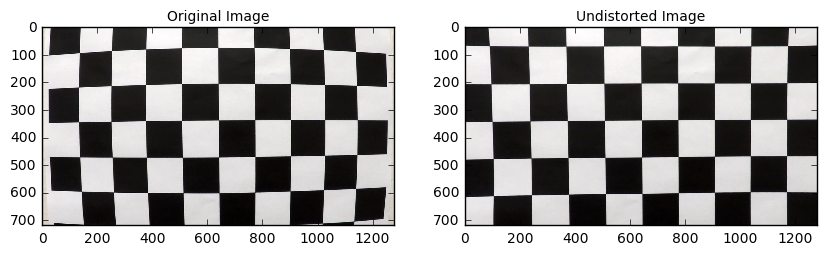

In [3]:
# Undistort chessboard image
image = mpimg.imread('./camera_cal/calibration1.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=10)

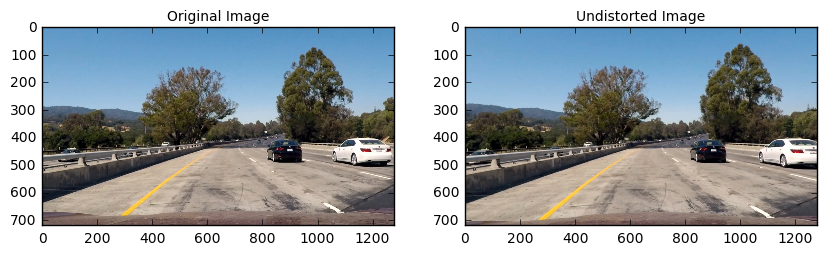

In [4]:
image = mpimg.imread('./test_images/test1.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=10)

In [5]:
def gradient_color_threshold(image, mask_half=False):
    hls = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2HLS)
    gray = (0.5 * image[:, :, 0] + 0.4 * image[:, :, 1] + 0.1 * image[:, :, 2]).astype(np.uint8)
    s = hls[:, :, 2]

    _, gray_binary = cv2.threshold(gray.astype('uint8'), 150, 255, cv2.THRESH_BINARY)

    total_px = image.shape[0] * image.shape[1]
    laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
    mask_three = (laplacian < 0.15 * np.min(laplacian)).astype(np.uint8)
    if cv2.countNonZero(mask_three) / total_px < 0.01:
        laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
        mask_three = (laplacian < 0.075 * np.min(laplacian)).astype(np.uint8)

    _, s_binary = cv2.threshold(s.astype('uint8'), 150, 255, cv2.THRESH_BINARY)
    mask_two = s_binary

    combined_binary = np.clip(cv2.bitwise_and(gray_binary,
                                              cv2.bitwise_or(mask_three, mask_two)), 0, 1).astype('uint8')

    # Mask out top half of image to reduce distractions
    # Only used when unwarped image is passed in
    if mask_half:
        combined_binary[:ceil(image.shape[0] // 2)] = 0
    return combined_binary


def find_perspective_points(image):
    edges = gradient_color_threshold(image, True)

    # Computing perspective points automatically
    rho = 2  # distance resolution in pixels of the Hough grid
    theta = 1 * np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 100  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100  # minimum number of pixels making up a line
    max_line_gap = 25  # maximum gap in pixels between connectable line segments

    angle_min_mag = 20 * pi / 180
    angle_max_mag = 65 * pi / 180

    lane_markers_x = [[], []]
    lane_markers_y = [[], []]

    masked_edges = np.copy(edges)
    masked_edges[:edges.shape[0] * 6 // 10, :] = 0
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    for line in lines:
        for x1, y1, x2, y2 in line:
            theta = atan2(y1 - y2, x2 - x1)
            # rho = ((x1 + x2) * cos(theta) + (y1 + y2) * sin(theta)) / 2
            if (abs(theta) >= angle_min_mag) and (abs(theta) <= angle_max_mag):
                if theta > 0:
                    i = 0  # Left lane marker
                else:
                    i = 1  # Right lane marker
                lane_markers_x[i].append(x1)
                lane_markers_x[i].append(x2)
                lane_markers_y[i].append(y1)
                lane_markers_y[i].append(y2)

    if len(lane_markers_x[0]) < 1 or len(lane_markers_x[1]) < 1:
        # Failed to find two lane markers
        return None

    p_left = np.polyfit(lane_markers_y[0], lane_markers_x[0], 1)
    p_right = np.polyfit(lane_markers_y[1], lane_markers_x[1], 1)

    # Find intersection of the two lines
    apex_pt = np.linalg.solve([[p_left[0], -1], [p_right[0], -1]], [-p_left[1], -p_right[1]])
    top_y = ceil(apex_pt[0] + 0.075 * edges.shape[0])

    bl_pt = ceil(np.polyval(p_left, edges.shape[0]))
    tl_pt = ceil(np.polyval(p_left, top_y))

    br_pt = ceil(np.polyval(p_right, edges.shape[0]))
    tr_pt = ceil(np.polyval(p_right, top_y))

    src = np.array([[tl_pt, top_y],
                    [tr_pt, top_y],
                    [br_pt, edges.shape[0]],
                    [bl_pt, edges.shape[0]]], np.float32)

    # get_perspective_transform(edges, src_in=src, dst_in=None, display=False)
    return src


def get_perspective_transform(image, src_in=None, dst_in=None, display=False):
    img_size = image.shape
    if src_in is None:
        src = np.array([[585. / 1280. * img_size[1], 455. / 720. * img_size[0]],
                        [705. / 1280. * img_size[1], 455. / 720. * img_size[0]],
                        [1130. / 1280. * img_size[1], 720. / 720. * img_size[0]],
                        [190. / 1280. * img_size[1], 720. / 720. * img_size[0]]], np.float32)
    else:
        src = src_in

    if dst_in is None:
        dst = np.array([[300. / 1280. * img_size[1], 100. / 720. * img_size[0]],
                        [1000. / 1280. * img_size[1], 100. / 720. * img_size[0]],
                        [1000. / 1280. * img_size[1], 720. / 720. * img_size[0]],
                        [300. / 1280. * img_size[1], 720. / 720. * img_size[0]]], np.float32)
    else:
        dst = dst_in

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

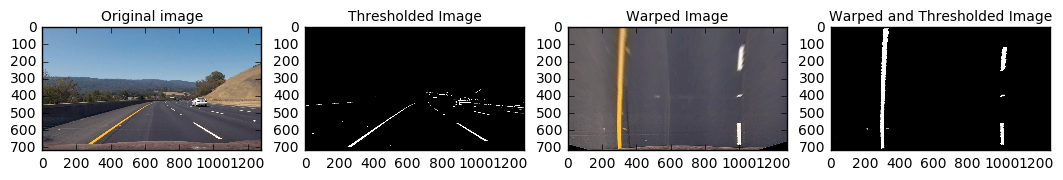

In [6]:
image = mpimg.imread('test_images/test3.jpg')
src = find_perspective_points(image)
undist = cv2.undistort(image, mtx, dist, None, mtx)

# https://www.packtpub.com/mapt/book/Application+Development/9781785283932/2/ch02lvl1sec22/Sharpening
kernel_sharpen = np.array([[-1, -1, -1, -1, -1],
                           [-1, 2, 2, 2, -1],
                           [-1, 2, 8, 2, -1],
                           [-1, 2, 2, 2, -1],
                           [-1, -1, -1, -1, -1]]) / 8.0

edges = gradient_color_threshold(undist, mask_half=True)

M, Minv = get_perspective_transform(undist, src, display=False)
warped_edges = cv2.warpPerspective(edges, M, (undist.shape[1], undist.shape[0]), flags=cv2.INTER_LINEAR)

warped = cv2.warpPerspective(undist, M, (undist.shape[1], undist.shape[0]), flags=cv2.INTER_LINEAR)
warped = cv2.filter2D(warped, -1, kernel_sharpen)

f, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(13, 6.5))
ax0.imshow(image)
ax0.set_title('Original image', fontsize=10)
ax1.imshow(edges, cmap='gray')
ax1.set_title('Thresholded Image', fontsize=10)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=10)
ax3.imshow(warped_edges, cmap='gray')
ax3.set_title('Warped and Thresholded Image', fontsize=10)

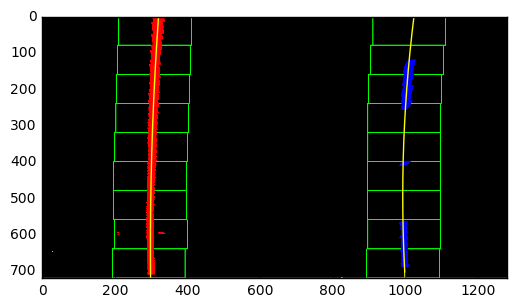

In [10]:
def sliding_window(warped_edges):

    histogram = np.sum(warped_edges[warped_edges.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped_edges, warped_edges, warped_edges))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped_edges.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_edges.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_edges.shape[0] - (window+1)*window_height
        win_y_high = warped_edges.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_edges.shape[0]-1, warped_edges.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return nonzeroy, nonzerox, left_lane_inds, right_lane_inds, left_fitx, margin, ploty, right_fitx

nonzeroy, nonzerox, left_lane_inds, right_lane_inds, left_fitx, margin, ploty, right_fitx = sliding_window(warped_edges)

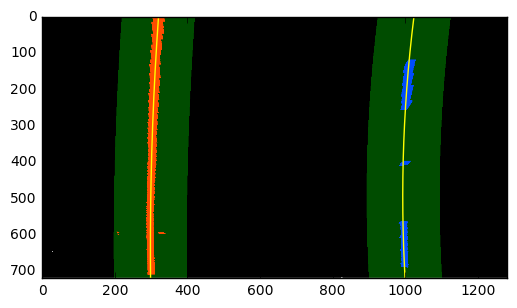

In [12]:
def searchable_area(warped_image, nonzeroy, nonzerox, left_lane_inds, right_lane_inds, left_fitx, margin, ploty, right_fitx):
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped_image, warped_image, warped_image))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return None

searchable_area(warped_edges, nonzeroy, nonzerox, left_lane_inds, right_lane_inds, left_fitx, margin, ploty, right_fitx)

In [6]:
# Define a class to receive the characteristics of each line detection
import collections
from itertools import chain
from functools import reduce

ym_per_pix = 30 / 720  # meters per pixel in y dimension
xm_per_pix = 3.7 / 700  # meters per pixel in x dimension


class Line:
    def __init__(self, base_pt, img_size, cache_length):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = collections.deque(maxlen=cache_length)
        self.recent_yfitted = collections.deque(maxlen=cache_length)

        # average x values of the fitted line over the last n iterations
        self.bestx = None

        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        # distance in meters of vehicle center from the line
        self.insanity = 0.0

        self.current_xfit = None
        self.roi_mask = None

        self.img_size = img_size
        self.base_pt = base_pt

        self.yvals = np.linspace(0, img_size[0], 101)
        self.mask = np.ones(img_size, dtype=np.uint8) * 255

        self.dropped_frames = 0

    def add_lane_pixels(self, x, y):
        # Use all pixels from previous detections for curve fit
        weights = np.ones(len(self.recent_xfitted))
        if len(weights) > 1:
            weights[0] = 0.8
            weights[1:] = 0.2 / (len(weights) - 1)

            w_x = reduce(lambda a, b: a + b[0] * b[1], zip(weights, self.recent_xfitted), np.zeros(len(self.yvals)))
            w_y = reduce(lambda a, b: a + b[0] * b[1], zip(weights, self.recent_yfitted), np.zeros(len(self.yvals)))
        else:
            w_x, w_y = [], []
        x_hist = np.fromiter(chain(w_x, x), np.int32)
        y_hist = np.fromiter(chain(w_y, y), np.int32)

        try:
            p_lane = np.polyfit(y_hist, x_hist, 2)
            rad_curv = self.compute_rad_curv(x_hist, y_hist)
            self.detected = self.sanity_check_lane(rad_curv)
        except Exception as e:
            print(e)
            self.detected = False

        if self.detected and len(p_lane) == 3:
            x_fit = p_lane[0] * self.yvals ** 2 + p_lane[1] * self.yvals + p_lane[2]

            self.current_xfit = x_fit 

            self.recent_xfitted.append(x_fit)
            self.recent_yfitted.append(self.yvals)

            self.radius_of_curvature = rad_curv
            self.current_fit = p_lane
            self.dropped_frames = 0
        else:
            # Sanity check failed
            # Use last fit if current one failed
            p_lane = self.current_fit
            rad_curv = self.radius_of_curvature
            x_fit = p_lane[0] * self.yvals ** 2 + p_lane[1] * self.yvals + p_lane[2]
            self.dropped_frames += 1

        # Update ROI mask
        self.mask.fill(0)
        # http://stackoverflow.com/a/35902430/538379
        pts = np.transpose(np.vstack([x_fit, self.yvals])).reshape((-1, 1, 2)).astype(np.int32)
        cv2.drawContours(self.mask, pts, -1, (255, 255, 255), thickness=80)

    @staticmethod
    def compute_rad_curv(xvals, yvals):
        fit_cr = np.polyfit(yvals * ym_per_pix, xvals * xm_per_pix, 2)
        y_eval = np.max(yvals)
        curverad = ((1 + (2 * fit_cr[0] * y_eval + fit_cr[1]) ** 2) ** 1.5) \
                   / np.absolute(2 * fit_cr[0])
        return curverad

    def sanity_check_lane(self, R):
        """
        Checks new radius of curvature `R` against the radius stored in the object.
        """
        # Return true if there is no prior data
        if self.radius_of_curvature is None:
            return True

    #   k = 1 / R  # Curvature is a better measure to track
        R0 = self.radius_of_curvature
    #    k0 = 1 / self.radius_of_curvature
        self.insanity = abs(R - R0) / R0
        return self.insanity <= 0.5  # Max change from frame to frame is 200%

    def detect_from_mask(self, image):
        mask_lanes = cv2.bitwise_and(image, self.mask)
        all_pts = cv2.findNonZero(mask_lanes)
        if all_pts is not None:
            all_pts = all_pts.reshape((-1, 2))
            self.add_lane_pixels(all_pts[:, 0], all_pts[:, 1])
        else:
            self.detected = False

    def draw_lane(self, image):
        """
        Draws lane on given image
        """
        pts = np.array([np.transpose(np.vstack([self.current_xfit, self.yvals]))])
        cv2.fillPoly(image, np.int_([pts]), (0, 255, 0))
        return image


def reject_outliers(x_list, y_list):
    if not x_list or not y_list:
        return x_list, y_list
    mu_x, mu_y = np.mean(x_list), np.mean(y_list)
    sig_x, sig_y = np.std(x_list), np.std(y_list)
    new_x, new_y = zip(*[(x, y) for (x, y) in zip(x_list, y_list)
                         if abs(x - mu_x) < 2 * sig_x and abs(y - mu_y) < 2 * sig_y])
    return new_x, new_y


def histogram_lane_detection(image, left_lane, right_lane, base_pts, num_bands=10, window_width=0.2):
    """Uses histogram and sliding window to detect lanes from scratch"""

    height = image.shape[0]
    band_height = int(1. / num_bands * height)  # Divide image into horizontal bands
    band_width = int(window_width * image.shape[1])

    l_x, l_y, r_x, r_y = [], [], [], []

    base_left, base_right = base_pts

    # idx_left, idx_right = base_pts
    for i in reversed(range(num_bands)):
        w_left = image[i * band_height:(i + 1) * band_height, base_left - band_width // 2:base_left + band_width // 2]
        w_right = image[i * band_height:(i + 1) * band_height,
                  base_right - band_width // 2:base_right + band_width // 2]

        left_y_pt, left_x_pt = np.nonzero(w_left)
        right_y_pt, right_x_pt = np.nonzero(w_right)

        l_x.extend(left_x_pt + base_left - band_width // 2)
        l_y.extend(left_y_pt + i * band_height)
        r_x.extend(right_x_pt + base_right - band_width // 2)
        r_y.extend(right_y_pt + i * band_height)

        # Find 'x' with maximum nonzero elements as baseline for next window
        s_left = np.sum(w_left, axis=0)
        s_right = np.sum(w_right, axis=0)
        if np.any(s_left > 0):
            base_left = np.argmax(s_left) + base_left - band_width // 2
        if np.any(s_right > 0):
            base_right = np.argmax(s_right) + base_right - band_width // 2

    l_x, l_y = reject_outliers(l_x, l_y)
    r_x, r_y = reject_outliers(r_x, r_y)

    left_lane.add_lane_pixels(l_x, l_y)
    right_lane.add_lane_pixels(r_x, r_y)

    return left_lane, right_lane

In [7]:
from scipy.signal import find_peaks_cwt


def find_base_points(lanes, min_peak=25.0):
    """Uses histogram to find possible base points for lane lines"""
    histogram = np.sum(lanes[int(lanes.shape[0] * 0.5):, :], axis=0)

    widths = [100]
    idx = find_peaks_cwt(histogram, widths, max_distances=widths, noise_perc=50)
    if len(idx) < 2:
        return None

    # Avoid edges
    idx = [i for i in idx if i > lanes.shape[1] * 0.1
           and i < lanes.shape[1] * 0.9
           and max(histogram[i - 50:i + 50]) > min_peak]
    return [min(idx), max(idx)], histogram

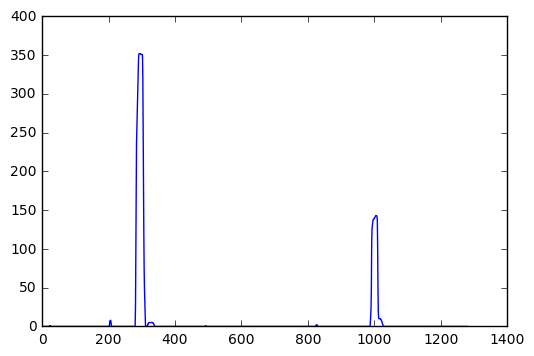

In [8]:
image = mpimg.imread('test_images/test3.jpg')

undist = cv2.undistort(image, mtx, dist, None, mtx)

yellow = (np.array([160, 128, 0]), np.array([255, 255, 128]))
hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)

src = find_perspective_points(undist)
M, Minv = get_perspective_transform(undist, src, display=True)

edges = gradient_color_threshold(undist, mask_half=True)
lanes = cv2.warpPerspective(edges, M, (undist.shape[1], undist.shape[0]), flags=cv2.INTER_LINEAR)

base_pts, histogram = find_base_points(lanes)

plt.plot(histogram)

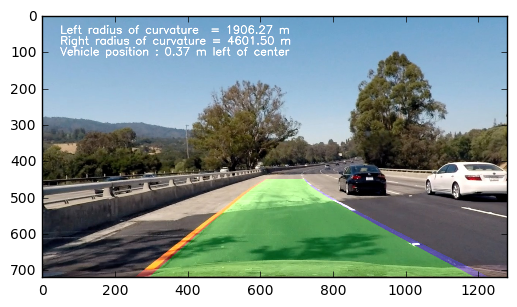

In [9]:
def process_image(image, cache_length=10):
    global cam_mtx, cam_dist

    if process_image.cache is None:

        left_lane = Line(int(0.16 * image.shape[0]), image.shape[:2], cache_length=cache_length)
        right_lane = Line(int(0.62 * image.shape[0]), image.shape[:2], cache_length=cache_length)

        cache = {'mtx': mtx,
                 'dist': dist,
                 'M': None,
                 'Minv': None,
                 'frame_ctr': 0,
                 'left': left_lane,
                 'right': right_lane,
                 'base_pts': None}
    else:
        cache = process_image.cache

    left_lane = cache['left']
    right_lane = cache['right']

    # Preprocess image and find edges using thresholding
    undist = cv2.undistort(image, mtx, dist, None, mtx)

    if cache['M'] is None:
        src = find_perspective_points(undist)
        M, Minv = get_perspective_transform(image, src_in=src)

        if src is not None:
            # Save only if customized perspective transform is found
            cache['M'] = M
            cache['Minv'] = Minv
    else:
        M, Minv = cache['M'], cache['Minv']

    warp_img = cv2.warpPerspective(undist, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    warp_edges = gradient_color_threshold(warp_img)

    base_pts = cache['base_pts']
    if base_pts is None:
        new_base_pts, _ = find_base_points(warp_edges)

        if new_base_pts is not None:
            base_pts = new_base_pts
        else:
            # Re-use previous data if base points could not be found
            cache['frame_ctr'] -= 1
            return undist

    if ((left_lane.current_xfit is None or left_lane.dropped_frames > 16)
        or (right_lane.current_xfit is None or right_lane.dropped_frames > 16)):
        # Detect from scratch
        left_lane.radius_of_curvature = None
        right_lane.radius_of_curvature = None
        histogram_lane_detection(warp_edges, left_lane, right_lane, base_pts)
    else:
        left_lane.detect_from_mask(warp_edges)
        right_lane.detect_from_mask(warp_edges)

    cache['frame_ctr'] += 1
    cache['base_pts'] = base_pts
    process_image.cache = cache

    yvals = left_lane.yvals
    left_fitx = left_lane.current_xfit
    right_fitx = right_lane.current_xfit

    # Create an image to draw the lines on
    color_warp = np.zeros_like(image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Draw lane markers
    pts = np.transpose(np.vstack([left_lane.current_xfit, left_lane.yvals])).reshape((-1, 1, 2)).astype(np.int32)
    cv2.drawContours(color_warp, pts, -1, (255, 0, 0), thickness=30)
    pts = np.transpose(np.vstack([right_lane.current_xfit, right_lane.yvals])).reshape((-1, 1, 2)).astype(np.int32)
    cv2.drawContours(color_warp, pts, -1, (0, 0, 255), thickness=30)

    # Warp the blank back to original image space using inverse perspective matrix
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    left_r = left_lane.radius_of_curvature
    right_r = right_lane.radius_of_curvature
    middle = (left_fitx[-1] + right_fitx[-1]) // 2
    veh_pos = image.shape[1] // 2

    dx = (veh_pos - middle) * xm_per_pix  # Positive if on right, Negative on left

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Left radius of curvature  = %.2f m' % left_r, (50, 50), font, 1, (255, 255, 255), 2,
                cv2.LINE_AA)
    cv2.putText(result, 'Right radius of curvature = %.2f m' % right_r, (50, 80), font, 1, (255, 255, 255), 2,
                cv2.LINE_AA)
    cv2.putText(result, 'Vehicle position : %.2f m %s of center' % (abs(dx), 'left' if dx < 0 else 'right'), (50, 110),
                font, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    # ax1.imshow(left_lane.mask, cmap='gray')
    # ax1.set_title('Left lane contour', fontsize=10)
    # ax2.imshow(right_lane.mask, cmap='gray')
    # ax2.set_title('Right lane contour', fontsize=10)
    # ax3.imshow(result)
    # ax3.set_title('Image with marked lanes', fontsize=10)

    cache['left'] = left_lane
    cache['right'] = right_lane

    return result


def clear_cache():
    process_image.cache = None

process_image.clear_cache = clear_cache
clear_cache()
image = mpimg.imread('test_images/test4.jpg')
result = process_image(image)
plt.imshow(result)

In [11]:
video_output = 'challenge_video_test.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image)  # NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

HTML("""
<video width="1260" height="720" controls>
  <source src="{0}">
</video>
""".format(video_output))

[MoviePy] >>>> Building video challenge_video_test.mp4


[MoviePy] Writing video challenge_video_test.mp4


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 1/485 [00:00<01:47,  4.48it/s]

  0%|          | 2/485 [00:00<01:52,  4.29it/s]

  1%|          | 3/485 [00:00<01:48,  4.45it/s]

  1%|          | 4/485 [00:00<01:51,  4.31it/s]

  1%|          | 5/485 [00:01<01:48,  4.41it/s]

  1%|          | 6/485 [00:01<01:45,  4.52it/s]

  1%|▏         | 7/485 [00:01<01:43,  4.62it/s]

  2%|▏         | 8/485 [00:01<01:41,  4.69it/s]

  2%|▏         | 9/485 [00:01<01:39,  4.76it/s]

  2%|▏         | 10/485 [00:02<01:39,  4.79it/s]

  2%|▏         | 11/485 [00:02<01:37,  4.85it/s]

  2%|▏         | 12/485 [00:02<01:36,  4.89it/s]

  3%|▎         | 13/485 [00:02<01:36,  4.88it/s]

  3%|▎         | 14/485 [00:02<01:36,  4.90it/s]

  3%|▎         | 15/485 [00:03<01:36,  4.89it/s]

  3%|▎         | 16/485 [00:03<01:35,  4.90it/s]

  4%|▎         | 17/485 [00:03<01:35,  4.90it/s]

  4%|▎         | 18/485 [00:03<01:37,  4.78it/s]

  4%|▍         | 19/485 [00:04<01:37,  4.78it/s]

  4%|▍         | 20/485 [00:04<01:37,  4.79it/s]

  4%|▍         | 21/485 [00:04<01:36,  4.82it/s]

  5%|▍         | 22/485 [00:04<01:41,  4.58it/s]

  5%|▍         | 23/485 [00:04<01:46,  4.35it/s]

  5%|▍         | 24/485 [00:05<01:46,  4.33it/s]

  5%|▌         | 25/485 [00:05<01:46,  4.34it/s]

  5%|▌         | 26/485 [00:05<01:42,  4.48it/s]

  6%|▌         | 27/485 [00:05<01:39,  4.59it/s]

  6%|▌         | 28/485 [00:06<01:37,  4.67it/s]

  6%|▌         | 29/485 [00:06<01:35,  4.77it/s]

  6%|▌         | 30/485 [00:06<01:33,  4.84it/s]

  6%|▋         | 31/485 [00:06<01:32,  4.89it/s]

  7%|▋         | 32/485 [00:06<01:31,  4.94it/s]

  7%|▋         | 33/485 [00:07<01:31,  4.96it/s]

  7%|▋         | 34/485 [00:07<01:31,  4.91it/s]

  7%|▋         | 35/485 [00:07<01:31,  4.93it/s]

  7%|▋         | 36/485 [00:07<01:31,  4.92it/s]

  8%|▊         | 37/485 [00:07<01:31,  4.90it/s]

  8%|▊         | 38/485 [00:08<01:30,  4.93it/s]

  8%|▊         | 39/485 [00:08<01:30,  4.90it/s]

  8%|▊         | 40/485 [00:08<01:30,  4.92it/s]

  8%|▊         | 41/485 [00:08<01:30,  4.93it/s]

  9%|▊         | 42/485 [00:08<01:30,  4.90it/s]

  9%|▉         | 43/485 [00:09<01:34,  4.69it/s]

  9%|▉         | 44/485 [00:09<01:35,  4.63it/s]

  9%|▉         | 45/485 [00:09<01:33,  4.70it/s]

  9%|▉         | 46/485 [00:09<01:32,  4.75it/s]

 10%|▉         | 47/485 [00:09<01:33,  4.70it/s]

 10%|▉         | 48/485 [00:10<01:34,  4.64it/s]

 10%|█         | 49/485 [00:10<01:33,  4.65it/s]

 10%|█         | 50/485 [00:10<01:34,  4.62it/s]

 11%|█         | 51/485 [00:10<01:35,  4.55it/s]

 11%|█         | 52/485 [00:11<01:34,  4.58it/s]

 11%|█         | 53/485 [00:11<01:34,  4.58it/s]

 11%|█         | 54/485 [00:11<01:34,  4.56it/s]

 11%|█▏        | 55/485 [00:11<01:35,  4.49it/s]

 12%|█▏        | 56/485 [00:11<01:35,  4.50it/s]

 12%|█▏        | 57/485 [00:12<01:34,  4.53it/s]

 12%|█▏        | 58/485 [00:12<01:33,  4.58it/s]

 12%|█▏        | 59/485 [00:12<01:32,  4.59it/s]

 12%|█▏        | 60/485 [00:12<01:33,  4.56it/s]

 13%|█▎        | 61/485 [00:13<01:34,  4.48it/s]

 13%|█▎        | 62/485 [00:13<01:35,  4.41it/s]

 13%|█▎        | 63/485 [00:13<01:34,  4.45it/s]

 13%|█▎        | 64/485 [00:13<01:35,  4.40it/s]

 13%|█▎        | 65/485 [00:13<01:35,  4.42it/s]

 14%|█▎        | 66/485 [00:14<01:34,  4.42it/s]

 14%|█▍        | 67/485 [00:14<01:28,  4.73it/s]

 14%|█▍        | 68/485 [00:14<01:23,  4.99it/s]

 14%|█▍        | 69/485 [00:14<01:20,  5.20it/s]

 14%|█▍        | 70/485 [00:14<01:24,  4.93it/s]

 15%|█▍        | 71/485 [00:15<01:25,  4.83it/s]

 15%|█▍        | 72/485 [00:15<01:27,  4.72it/s]

 15%|█▌        | 73/485 [00:15<01:28,  4.66it/s]

 15%|█▌        | 74/485 [00:15<01:29,  4.59it/s]

 15%|█▌        | 75/485 [00:16<01:30,  4.55it/s]

 16%|█▌        | 76/485 [00:16<01:30,  4.51it/s]

 16%|█▌        | 77/485 [00:16<01:30,  4.51it/s]

 16%|█▌        | 78/485 [00:16<01:31,  4.46it/s]

 16%|█▋        | 79/485 [00:16<01:30,  4.48it/s]

 16%|█▋        | 80/485 [00:17<01:32,  4.38it/s]

 17%|█▋        | 81/485 [00:17<01:35,  4.24it/s]

 17%|█▋        | 82/485 [00:17<01:33,  4.29it/s]

 17%|█▋        | 83/485 [00:17<01:32,  4.36it/s]

 17%|█▋        | 84/485 [00:18<01:31,  4.38it/s]

 18%|█▊        | 85/485 [00:18<01:31,  4.38it/s]

 18%|█▊        | 86/485 [00:18<01:29,  4.45it/s]

 18%|█▊        | 87/485 [00:18<01:28,  4.48it/s]

 18%|█▊        | 88/485 [00:18<01:28,  4.47it/s]

 18%|█▊        | 89/485 [00:19<01:28,  4.50it/s]

 19%|█▊        | 90/485 [00:19<01:27,  4.49it/s]

 19%|█▉        | 91/485 [00:19<01:28,  4.47it/s]

 19%|█▉        | 92/485 [00:19<01:27,  4.49it/s]

 19%|█▉        | 93/485 [00:20<01:28,  4.45it/s]

 19%|█▉        | 94/485 [00:20<01:28,  4.41it/s]

 20%|█▉        | 95/485 [00:20<01:27,  4.44it/s]

 20%|█▉        | 96/485 [00:20<01:27,  4.44it/s]

 20%|██        | 97/485 [00:21<01:27,  4.45it/s]

 20%|██        | 98/485 [00:21<01:26,  4.47it/s]

 20%|██        | 99/485 [00:21<01:26,  4.47it/s]

 21%|██        | 100/485 [00:21<01:25,  4.49it/s]

 21%|██        | 101/485 [00:21<01:25,  4.52it/s]

 21%|██        | 102/485 [00:22<01:25,  4.47it/s]

 21%|██        | 103/485 [00:22<01:25,  4.46it/s]

 21%|██▏       | 104/485 [00:22<01:25,  4.44it/s]

 22%|██▏       | 105/485 [00:22<01:24,  4.51it/s]

 22%|██▏       | 106/485 [00:23<01:24,  4.48it/s]

 22%|██▏       | 107/485 [00:23<01:24,  4.48it/s]

 22%|██▏       | 108/485 [00:23<01:25,  4.43it/s]

 22%|██▏       | 109/485 [00:23<01:24,  4.47it/s]

 23%|██▎       | 110/485 [00:23<01:24,  4.44it/s]

 23%|██▎       | 111/485 [00:24<01:23,  4.49it/s]

 23%|██▎       | 112/485 [00:24<01:23,  4.45it/s]

 23%|██▎       | 113/485 [00:24<01:22,  4.50it/s]

 24%|██▎       | 114/485 [00:24<01:25,  4.35it/s]

 24%|██▎       | 115/485 [00:25<01:28,  4.20it/s]

 24%|██▍       | 116/485 [00:25<01:32,  4.01it/s]

 24%|██▍       | 117/485 [00:25<01:31,  4.01it/s]

 24%|██▍       | 118/485 [00:25<01:31,  4.01it/s]

 25%|██▍       | 119/485 [00:26<01:29,  4.08it/s]

 25%|██▍       | 120/485 [00:26<01:30,  4.03it/s]

 25%|██▍       | 121/485 [00:26<01:32,  3.94it/s]

 25%|██▌       | 122/485 [00:26<01:37,  3.74it/s]

 25%|██▌       | 123/485 [00:27<01:35,  3.77it/s]

 26%|██▌       | 124/485 [00:27<01:32,  3.92it/s]

 26%|██▌       | 125/485 [00:27<01:26,  4.14it/s]

 26%|██▌       | 126/485 [00:27<01:23,  4.30it/s]

 26%|██▌       | 127/485 [00:28<01:16,  4.66it/s]

 26%|██▋       | 128/485 [00:28<01:14,  4.82it/s]

 27%|██▋       | 129/485 [00:28<01:10,  5.07it/s]

 27%|██▋       | 130/485 [00:28<01:07,  5.25it/s]

 27%|██▋       | 131/485 [00:28<01:05,  5.40it/s]

 27%|██▋       | 132/485 [00:28<01:05,  5.40it/s]

 27%|██▋       | 133/485 [00:29<01:08,  5.11it/s]

 28%|██▊       | 134/485 [00:29<01:11,  4.89it/s]

 28%|██▊       | 135/485 [00:29<01:14,  4.73it/s]

 28%|██▊       | 136/485 [00:29<01:16,  4.56it/s]

 28%|██▊       | 137/485 [00:30<01:16,  4.56it/s]

 28%|██▊       | 138/485 [00:30<01:16,  4.54it/s]

 29%|██▊       | 139/485 [00:30<01:15,  4.56it/s]

 29%|██▉       | 140/485 [00:30<01:16,  4.53it/s]

 29%|██▉       | 141/485 [00:30<01:15,  4.58it/s]

 29%|██▉       | 142/485 [00:31<01:15,  4.53it/s]

 29%|██▉       | 143/485 [00:31<01:15,  4.54it/s]

 30%|██▉       | 144/485 [00:31<01:15,  4.54it/s]

 30%|██▉       | 145/485 [00:31<01:14,  4.59it/s]

 30%|███       | 146/485 [00:32<01:13,  4.59it/s]

 30%|███       | 147/485 [00:32<01:13,  4.58it/s]

 31%|███       | 148/485 [00:32<01:15,  4.47it/s]

 31%|███       | 149/485 [00:32<01:14,  4.49it/s]

 31%|███       | 150/485 [00:32<01:19,  4.24it/s]

 31%|███       | 151/485 [00:33<01:19,  4.21it/s]

 31%|███▏      | 152/485 [00:33<01:19,  4.21it/s]

 32%|███▏      | 153/485 [00:33<01:17,  4.27it/s]

 32%|███▏      | 154/485 [00:33<01:17,  4.29it/s]

 32%|███▏      | 155/485 [00:34<01:11,  4.59it/s]

 32%|███▏      | 156/485 [00:34<01:09,  4.75it/s]

 32%|███▏      | 157/485 [00:34<01:05,  5.00it/s]

 33%|███▎      | 158/485 [00:34<01:05,  5.02it/s]

 33%|███▎      | 159/485 [00:34<01:07,  4.83it/s]

 33%|███▎      | 160/485 [00:35<01:09,  4.70it/s]

 33%|███▎      | 161/485 [00:35<01:09,  4.63it/s]

 33%|███▎      | 162/485 [00:35<01:10,  4.59it/s]

 34%|███▎      | 163/485 [00:35<01:10,  4.54it/s]

 34%|███▍      | 164/485 [00:35<01:11,  4.49it/s]

 34%|███▍      | 165/485 [00:36<01:12,  4.41it/s]

 34%|███▍      | 166/485 [00:36<01:12,  4.42it/s]

 34%|███▍      | 167/485 [00:36<01:11,  4.44it/s]

 35%|███▍      | 168/485 [00:36<01:11,  4.41it/s]

 35%|███▍      | 169/485 [00:37<01:12,  4.36it/s]

 35%|███▌      | 170/485 [00:37<01:14,  4.22it/s]

 35%|███▌      | 171/485 [00:37<01:14,  4.19it/s]

 35%|███▌      | 172/485 [00:37<01:19,  3.93it/s]

 36%|███▌      | 173/485 [00:38<01:43,  3.02it/s]

 36%|███▌      | 174/485 [00:38<01:44,  2.98it/s]

 36%|███▌      | 175/485 [00:39<01:40,  3.09it/s]

 36%|███▋      | 176/485 [00:39<01:44,  2.94it/s]

 36%|███▋      | 177/485 [00:39<01:43,  2.97it/s]

 37%|███▋      | 178/485 [00:40<01:46,  2.89it/s]

 37%|███▋      | 179/485 [00:40<02:11,  2.33it/s]

 37%|███▋      | 180/485 [00:41<01:59,  2.55it/s]

 37%|███▋      | 181/485 [00:41<01:52,  2.71it/s]

 38%|███▊      | 182/485 [00:41<01:50,  2.73it/s]

 38%|███▊      | 183/485 [00:42<01:50,  2.74it/s]

 38%|███▊      | 184/485 [00:42<01:46,  2.82it/s]

 38%|███▊      | 185/485 [00:42<01:34,  3.16it/s]

 38%|███▊      | 186/485 [00:42<01:26,  3.44it/s]

 39%|███▊      | 187/485 [00:43<01:23,  3.59it/s]

 39%|███▉      | 188/485 [00:43<01:20,  3.67it/s]

 39%|███▉      | 189/485 [00:43<01:19,  3.74it/s]

 39%|███▉      | 190/485 [00:43<01:17,  3.82it/s]

 39%|███▉      | 191/485 [00:44<01:21,  3.63it/s]

 40%|███▉      | 192/485 [00:44<01:26,  3.39it/s]

 40%|███▉      | 193/485 [00:44<01:22,  3.55it/s]

 40%|████      | 194/485 [00:45<01:28,  3.28it/s]

 40%|████      | 195/485 [00:45<01:33,  3.11it/s]

 40%|████      | 196/485 [00:45<01:35,  3.04it/s]

 41%|████      | 197/485 [00:46<01:34,  3.05it/s]

 41%|████      | 198/485 [00:46<01:57,  2.44it/s]

 41%|████      | 199/485 [00:47<01:56,  2.46it/s]

 41%|████      | 200/485 [00:47<01:46,  2.67it/s]

 41%|████▏     | 201/485 [00:47<01:37,  2.90it/s]

 42%|████▏     | 202/485 [00:48<01:34,  2.99it/s]

 42%|████▏     | 203/485 [00:48<01:30,  3.13it/s]

 42%|████▏     | 204/485 [00:48<01:28,  3.17it/s]

 42%|████▏     | 205/485 [00:48<01:28,  3.16it/s]

 42%|████▏     | 206/485 [00:49<01:34,  2.94it/s]

 43%|████▎     | 207/485 [00:49<01:34,  2.95it/s]

 43%|████▎     | 208/485 [00:50<01:33,  2.95it/s]

 43%|████▎     | 209/485 [00:50<01:31,  3.01it/s]

 43%|████▎     | 210/485 [00:50<01:30,  3.05it/s]

 44%|████▎     | 211/485 [00:50<01:24,  3.23it/s]

 44%|████▎     | 212/485 [00:51<01:23,  3.27it/s]

 44%|████▍     | 213/485 [00:51<01:21,  3.34it/s]

 44%|████▍     | 214/485 [00:51<01:19,  3.39it/s]

 44%|████▍     | 215/485 [00:52<01:15,  3.56it/s]

 45%|████▍     | 216/485 [00:52<01:20,  3.34it/s]

 45%|████▍     | 217/485 [00:52<01:18,  3.42it/s]

 45%|████▍     | 218/485 [00:52<01:16,  3.47it/s]

 45%|████▌     | 219/485 [00:53<01:16,  3.47it/s]

 45%|████▌     | 220/485 [00:53<01:16,  3.46it/s]

 46%|████▌     | 221/485 [00:53<01:15,  3.51it/s]

 46%|████▌     | 222/485 [00:54<01:15,  3.50it/s]

 46%|████▌     | 223/485 [00:54<01:14,  3.53it/s]

 46%|████▌     | 224/485 [00:54<01:14,  3.49it/s]

 46%|████▋     | 225/485 [00:54<01:13,  3.53it/s]

 47%|████▋     | 226/485 [00:55<01:12,  3.59it/s]

 47%|████▋     | 227/485 [00:55<01:11,  3.63it/s]

 47%|████▋     | 228/485 [00:55<01:12,  3.57it/s]

 47%|████▋     | 229/485 [00:56<01:10,  3.63it/s]

 47%|████▋     | 230/485 [00:56<01:10,  3.59it/s]

 48%|████▊     | 231/485 [00:56<01:09,  3.68it/s]

 48%|████▊     | 232/485 [00:56<01:08,  3.68it/s]

 48%|████▊     | 233/485 [00:57<01:09,  3.60it/s]

 48%|████▊     | 234/485 [00:57<01:09,  3.63it/s]

 48%|████▊     | 235/485 [00:57<01:07,  3.70it/s]

 49%|████▊     | 236/485 [00:57<01:07,  3.67it/s]

 49%|████▉     | 237/485 [00:58<01:07,  3.66it/s]

 49%|████▉     | 238/485 [00:58<01:07,  3.63it/s]

 49%|████▉     | 239/485 [00:58<01:09,  3.52it/s]

 49%|████▉     | 240/485 [00:59<01:10,  3.47it/s]

 50%|████▉     | 241/485 [00:59<01:11,  3.39it/s]

 50%|████▉     | 242/485 [00:59<01:09,  3.50it/s]

 50%|█████     | 243/485 [00:59<01:08,  3.54it/s]

 50%|█████     | 244/485 [01:00<01:07,  3.56it/s]

 51%|█████     | 245/485 [01:00<01:06,  3.59it/s]

 51%|█████     | 246/485 [01:00<01:05,  3.64it/s]

 51%|█████     | 247/485 [01:01<01:05,  3.64it/s]

 51%|█████     | 248/485 [01:01<01:07,  3.53it/s]

 51%|█████▏    | 249/485 [01:01<01:06,  3.55it/s]

 52%|█████▏    | 250/485 [01:01<01:06,  3.54it/s]

 52%|█████▏    | 251/485 [01:02<01:05,  3.56it/s]

 52%|█████▏    | 252/485 [01:02<01:06,  3.51it/s]

 52%|█████▏    | 253/485 [01:02<01:07,  3.45it/s]

 52%|█████▏    | 254/485 [01:03<01:09,  3.33it/s]

 53%|█████▎    | 255/485 [01:03<01:09,  3.33it/s]

 53%|█████▎    | 256/485 [01:03<01:08,  3.35it/s]

 53%|█████▎    | 257/485 [01:04<01:07,  3.37it/s]

 53%|█████▎    | 258/485 [01:04<01:06,  3.41it/s]

 53%|█████▎    | 259/485 [01:04<01:05,  3.46it/s]

 54%|█████▎    | 260/485 [01:04<01:04,  3.50it/s]

 54%|█████▍    | 261/485 [01:05<01:04,  3.49it/s]

 54%|█████▍    | 262/485 [01:05<01:03,  3.50it/s]

 54%|█████▍    | 263/485 [01:05<01:02,  3.55it/s]

 54%|█████▍    | 264/485 [01:05<01:01,  3.59it/s]

 55%|█████▍    | 265/485 [01:06<01:01,  3.55it/s]

 55%|█████▍    | 266/485 [01:06<01:00,  3.62it/s]

 55%|█████▌    | 267/485 [01:06<01:00,  3.59it/s]

 55%|█████▌    | 268/485 [01:07<01:00,  3.58it/s]

 55%|█████▌    | 269/485 [01:07<00:59,  3.63it/s]

 56%|█████▌    | 270/485 [01:07<00:59,  3.62it/s]

 56%|█████▌    | 271/485 [01:07<00:58,  3.64it/s]

 56%|█████▌    | 272/485 [01:08<00:59,  3.59it/s]

 56%|█████▋    | 273/485 [01:08<00:58,  3.63it/s]

 56%|█████▋    | 274/485 [01:08<00:58,  3.61it/s]

 57%|█████▋    | 275/485 [01:09<00:59,  3.54it/s]

 57%|█████▋    | 276/485 [01:09<01:00,  3.44it/s]

 57%|█████▋    | 277/485 [01:09<00:59,  3.47it/s]

 57%|█████▋    | 278/485 [01:09<00:58,  3.51it/s]

 58%|█████▊    | 279/485 [01:10<00:58,  3.54it/s]

 58%|█████▊    | 280/485 [01:10<00:56,  3.61it/s]

 58%|█████▊    | 281/485 [01:10<00:58,  3.48it/s]

 58%|█████▊    | 282/485 [01:11<00:57,  3.53it/s]

 58%|█████▊    | 283/485 [01:11<00:57,  3.52it/s]

 59%|█████▊    | 284/485 [01:11<00:57,  3.49it/s]

 59%|█████▉    | 285/485 [01:11<00:57,  3.48it/s]

 59%|█████▉    | 286/485 [01:12<00:55,  3.58it/s]

 59%|█████▉    | 287/485 [01:12<00:55,  3.54it/s]

 59%|█████▉    | 288/485 [01:12<00:55,  3.54it/s]

 60%|█████▉    | 289/485 [01:13<00:55,  3.53it/s]

 60%|█████▉    | 290/485 [01:13<00:55,  3.54it/s]

 60%|██████    | 291/485 [01:13<00:55,  3.48it/s]

 60%|██████    | 292/485 [01:13<00:55,  3.48it/s]

 60%|██████    | 293/485 [01:14<00:54,  3.52it/s]

 61%|██████    | 294/485 [01:14<00:53,  3.55it/s]

 61%|██████    | 295/485 [01:14<00:52,  3.60it/s]

 61%|██████    | 296/485 [01:14<00:52,  3.59it/s]

 61%|██████    | 297/485 [01:15<00:52,  3.59it/s]

 61%|██████▏   | 298/485 [01:15<00:51,  3.62it/s]

 62%|██████▏   | 299/485 [01:15<00:51,  3.63it/s]

 62%|██████▏   | 300/485 [01:16<00:51,  3.59it/s]

 62%|██████▏   | 301/485 [01:16<00:52,  3.50it/s]

 62%|██████▏   | 302/485 [01:16<00:51,  3.57it/s]

 62%|██████▏   | 303/485 [01:16<00:50,  3.61it/s]

 63%|██████▎   | 304/485 [01:17<00:51,  3.55it/s]

 63%|██████▎   | 305/485 [01:17<00:50,  3.59it/s]

 63%|██████▎   | 306/485 [01:17<00:50,  3.56it/s]

 63%|██████▎   | 307/485 [01:18<00:50,  3.52it/s]

 64%|██████▎   | 308/485 [01:18<00:50,  3.51it/s]

 64%|██████▎   | 309/485 [01:18<00:49,  3.58it/s]

 64%|██████▍   | 310/485 [01:18<00:49,  3.52it/s]

 64%|██████▍   | 311/485 [01:19<00:48,  3.56it/s]

 64%|██████▍   | 312/485 [01:19<00:47,  3.61it/s]

 65%|██████▍   | 313/485 [01:19<00:48,  3.55it/s]

 65%|██████▍   | 314/485 [01:20<00:47,  3.57it/s]

 65%|██████▍   | 315/485 [01:20<00:48,  3.52it/s]

 65%|██████▌   | 316/485 [01:20<00:47,  3.54it/s]

 65%|██████▌   | 317/485 [01:20<00:47,  3.52it/s]

 66%|██████▌   | 318/485 [01:21<00:46,  3.56it/s]

 66%|██████▌   | 319/485 [01:21<00:46,  3.55it/s]

 66%|██████▌   | 320/485 [01:21<00:47,  3.51it/s]

 66%|██████▌   | 321/485 [01:22<00:46,  3.49it/s]

 66%|██████▋   | 322/485 [01:22<00:49,  3.28it/s]

 67%|██████▋   | 323/485 [01:22<00:49,  3.25it/s]

 67%|██████▋   | 324/485 [01:23<00:51,  3.16it/s]

 67%|██████▋   | 325/485 [01:23<00:49,  3.25it/s]

 67%|██████▋   | 326/485 [01:23<00:47,  3.37it/s]

 67%|██████▋   | 327/485 [01:23<00:45,  3.46it/s]

 68%|██████▊   | 328/485 [01:24<00:44,  3.49it/s]

 68%|██████▊   | 329/485 [01:24<00:45,  3.41it/s]

 68%|██████▊   | 330/485 [01:24<00:44,  3.46it/s]

 68%|██████▊   | 331/485 [01:25<00:43,  3.54it/s]

 68%|██████▊   | 332/485 [01:25<00:42,  3.62it/s]

 69%|██████▊   | 333/485 [01:25<00:42,  3.54it/s]

 69%|██████▉   | 334/485 [01:25<00:41,  3.64it/s]

 69%|██████▉   | 335/485 [01:26<00:40,  3.69it/s]

 69%|██████▉   | 336/485 [01:26<00:39,  3.73it/s]

 69%|██████▉   | 337/485 [01:26<00:40,  3.65it/s]

 70%|██████▉   | 338/485 [01:26<00:41,  3.58it/s]

 70%|██████▉   | 339/485 [01:27<00:40,  3.57it/s]

 70%|███████   | 340/485 [01:27<00:40,  3.62it/s]

 70%|███████   | 341/485 [01:27<00:40,  3.57it/s]

 71%|███████   | 342/485 [01:28<00:40,  3.54it/s]

 71%|███████   | 343/485 [01:28<00:40,  3.49it/s]

 71%|███████   | 344/485 [01:28<00:40,  3.52it/s]

 71%|███████   | 345/485 [01:28<00:39,  3.55it/s]

 71%|███████▏  | 346/485 [01:29<00:38,  3.62it/s]

 72%|███████▏  | 347/485 [01:29<00:37,  3.72it/s]

 72%|███████▏  | 348/485 [01:29<00:37,  3.65it/s]

 72%|███████▏  | 349/485 [01:29<00:36,  3.70it/s]

 72%|███████▏  | 350/485 [01:30<00:35,  3.77it/s]

 72%|███████▏  | 351/485 [01:30<00:35,  3.80it/s]

 73%|███████▎  | 352/485 [01:30<00:35,  3.77it/s]

 73%|███████▎  | 353/485 [01:31<00:36,  3.67it/s]

 73%|███████▎  | 354/485 [01:31<00:36,  3.54it/s]

 73%|███████▎  | 355/485 [01:31<00:37,  3.48it/s]

 73%|███████▎  | 356/485 [01:31<00:36,  3.53it/s]

 74%|███████▎  | 357/485 [01:32<00:36,  3.50it/s]

 74%|███████▍  | 358/485 [01:32<00:35,  3.57it/s]

 74%|███████▍  | 359/485 [01:32<00:35,  3.59it/s]

 74%|███████▍  | 360/485 [01:33<00:35,  3.54it/s]

 74%|███████▍  | 361/485 [01:33<00:34,  3.57it/s]

 75%|███████▍  | 362/485 [01:33<00:34,  3.52it/s]

 75%|███████▍  | 363/485 [01:33<00:34,  3.58it/s]

 75%|███████▌  | 364/485 [01:34<00:34,  3.55it/s]

 75%|███████▌  | 365/485 [01:34<00:33,  3.62it/s]

 75%|███████▌  | 366/485 [01:34<00:33,  3.57it/s]

 76%|███████▌  | 367/485 [01:35<00:34,  3.44it/s]

 76%|███████▌  | 368/485 [01:35<00:34,  3.39it/s]

 76%|███████▌  | 369/485 [01:35<00:33,  3.41it/s]

 76%|███████▋  | 370/485 [01:35<00:33,  3.45it/s]

 76%|███████▋  | 371/485 [01:36<00:32,  3.52it/s]

 77%|███████▋  | 372/485 [01:36<00:32,  3.50it/s]

 77%|███████▋  | 373/485 [01:36<00:31,  3.60it/s]

 77%|███████▋  | 374/485 [01:37<00:31,  3.54it/s]

 77%|███████▋  | 375/485 [01:37<00:30,  3.58it/s]

 78%|███████▊  | 376/485 [01:37<00:30,  3.54it/s]

 78%|███████▊  | 377/485 [01:37<00:30,  3.57it/s]

 78%|███████▊  | 378/485 [01:38<00:30,  3.55it/s]

 78%|███████▊  | 379/485 [01:38<00:29,  3.62it/s]

 78%|███████▊  | 380/485 [01:38<00:29,  3.57it/s]

 79%|███████▊  | 381/485 [01:38<00:28,  3.61it/s]

 79%|███████▉  | 382/485 [01:39<00:28,  3.57it/s]

 79%|███████▉  | 383/485 [01:39<00:28,  3.57it/s]

 79%|███████▉  | 384/485 [01:39<00:28,  3.57it/s]

 79%|███████▉  | 385/485 [01:40<00:28,  3.54it/s]

 80%|███████▉  | 386/485 [01:40<00:27,  3.55it/s]

 80%|███████▉  | 387/485 [01:40<00:28,  3.49it/s]

 80%|████████  | 388/485 [01:40<00:27,  3.50it/s]

 80%|████████  | 389/485 [01:41<00:27,  3.49it/s]

 80%|████████  | 390/485 [01:41<00:26,  3.54it/s]

 81%|████████  | 391/485 [01:41<00:26,  3.56it/s]

 81%|████████  | 392/485 [01:42<00:25,  3.59it/s]

 81%|████████  | 393/485 [01:42<00:25,  3.62it/s]

 81%|████████  | 394/485 [01:42<00:24,  3.64it/s]

 81%|████████▏ | 395/485 [01:42<00:25,  3.56it/s]

 82%|████████▏ | 396/485 [01:43<00:24,  3.57it/s]

 82%|████████▏ | 397/485 [01:43<00:24,  3.56it/s]

 82%|████████▏ | 398/485 [01:43<00:24,  3.60it/s]

 82%|████████▏ | 399/485 [01:44<00:23,  3.64it/s]

 82%|████████▏ | 400/485 [01:44<00:23,  3.68it/s]

 83%|████████▎ | 401/485 [01:44<00:23,  3.61it/s]

 83%|████████▎ | 402/485 [01:44<00:23,  3.60it/s]

 83%|████████▎ | 403/485 [01:45<00:23,  3.56it/s]

 83%|████████▎ | 404/485 [01:45<00:22,  3.60it/s]

 84%|████████▎ | 405/485 [01:45<00:22,  3.62it/s]

 84%|████████▎ | 406/485 [01:45<00:22,  3.54it/s]

 84%|████████▍ | 407/485 [01:46<00:22,  3.51it/s]

 84%|████████▍ | 408/485 [01:46<00:21,  3.56it/s]

 84%|████████▍ | 409/485 [01:46<00:21,  3.53it/s]

 85%|████████▍ | 410/485 [01:47<00:19,  3.82it/s]

 85%|████████▍ | 411/485 [01:47<00:19,  3.76it/s]

 85%|████████▍ | 412/485 [01:47<00:19,  3.73it/s]

 85%|████████▌ | 413/485 [01:47<00:19,  3.65it/s]

 85%|████████▌ | 414/485 [01:48<00:19,  3.65it/s]

 86%|████████▌ | 415/485 [01:48<00:19,  3.61it/s]

 86%|████████▌ | 416/485 [01:48<00:19,  3.59it/s]

 86%|████████▌ | 417/485 [01:48<00:19,  3.58it/s]

 86%|████████▌ | 418/485 [01:49<00:18,  3.55it/s]

 86%|████████▋ | 419/485 [01:49<00:18,  3.59it/s]

 87%|████████▋ | 420/485 [01:49<00:18,  3.57it/s]

 87%|████████▋ | 421/485 [01:50<00:17,  3.56it/s]

 87%|████████▋ | 422/485 [01:50<00:17,  3.55it/s]

 87%|████████▋ | 423/485 [01:50<00:17,  3.63it/s]

 87%|████████▋ | 424/485 [01:50<00:16,  3.64it/s]

 88%|████████▊ | 425/485 [01:51<00:16,  3.68it/s]

 88%|████████▊ | 426/485 [01:51<00:16,  3.66it/s]

 88%|████████▊ | 427/485 [01:51<00:15,  3.68it/s]

 88%|████████▊ | 428/485 [01:52<00:15,  3.66it/s]

 88%|████████▊ | 429/485 [01:52<00:15,  3.62it/s]

 89%|████████▊ | 430/485 [01:52<00:15,  3.60it/s]

 89%|████████▉ | 431/485 [01:52<00:15,  3.57it/s]

 89%|████████▉ | 432/485 [01:53<00:15,  3.52it/s]

 89%|████████▉ | 433/485 [01:53<00:14,  3.54it/s]

 89%|████████▉ | 434/485 [01:53<00:14,  3.55it/s]

 90%|████████▉ | 435/485 [01:53<00:13,  3.58it/s]

 90%|████████▉ | 436/485 [01:54<00:13,  3.60it/s]

 90%|█████████ | 437/485 [01:54<00:13,  3.52it/s]

 90%|█████████ | 438/485 [01:54<00:13,  3.57it/s]

 91%|█████████ | 439/485 [01:55<00:13,  3.54it/s]

 91%|█████████ | 440/485 [01:55<00:12,  3.54it/s]

 91%|█████████ | 441/485 [01:55<00:12,  3.54it/s]

 91%|█████████ | 442/485 [01:55<00:12,  3.58it/s]

 91%|█████████▏| 443/485 [01:56<00:11,  3.59it/s]

 92%|█████████▏| 444/485 [01:56<00:11,  3.54it/s]

 92%|█████████▏| 445/485 [01:56<00:11,  3.61it/s]

 92%|█████████▏| 446/485 [01:57<00:10,  3.62it/s]

 92%|█████████▏| 447/485 [01:57<00:09,  3.82it/s]

 92%|█████████▏| 448/485 [01:57<00:10,  3.68it/s]

 93%|█████████▎| 449/485 [01:57<00:09,  3.68it/s]

 93%|█████████▎| 450/485 [01:58<00:09,  3.65it/s]

 93%|█████████▎| 451/485 [01:58<00:09,  3.53it/s]

 93%|█████████▎| 452/485 [01:58<00:09,  3.56it/s]

 93%|█████████▎| 453/485 [01:59<00:08,  3.58it/s]

 94%|█████████▎| 454/485 [01:59<00:08,  3.59it/s]

 94%|█████████▍| 455/485 [01:59<00:08,  3.58it/s]

 94%|█████████▍| 456/485 [01:59<00:08,  3.57it/s]

 94%|█████████▍| 457/485 [02:00<00:07,  3.56it/s]

 94%|█████████▍| 458/485 [02:00<00:07,  3.55it/s]

 95%|█████████▍| 459/485 [02:00<00:07,  3.52it/s]

 95%|█████████▍| 460/485 [02:00<00:06,  3.58it/s]

 95%|█████████▌| 461/485 [02:01<00:06,  3.60it/s]

 95%|█████████▌| 462/485 [02:01<00:06,  3.56it/s]

 95%|█████████▌| 463/485 [02:01<00:06,  3.59it/s]

 96%|█████████▌| 464/485 [02:02<00:05,  3.62it/s]

 96%|█████████▌| 465/485 [02:02<00:05,  3.54it/s]

 96%|█████████▌| 466/485 [02:02<00:05,  3.57it/s]

 96%|█████████▋| 467/485 [02:02<00:05,  3.54it/s]

 96%|█████████▋| 468/485 [02:03<00:04,  3.52it/s]

 97%|█████████▋| 469/485 [02:03<00:04,  3.54it/s]

 97%|█████████▋| 470/485 [02:03<00:04,  3.57it/s]

 97%|█████████▋| 471/485 [02:04<00:03,  3.53it/s]

 97%|█████████▋| 472/485 [02:04<00:03,  3.58it/s]

 98%|█████████▊| 473/485 [02:04<00:03,  3.59it/s]

 98%|█████████▊| 474/485 [02:04<00:03,  3.52it/s]

 98%|█████████▊| 475/485 [02:05<00:02,  3.60it/s]

 98%|█████████▊| 476/485 [02:05<00:02,  3.66it/s]

 98%|█████████▊| 477/485 [02:05<00:02,  3.64it/s]

 99%|█████████▊| 478/485 [02:05<00:01,  3.65it/s]

 99%|█████████▉| 479/485 [02:06<00:01,  3.57it/s]

 99%|█████████▉| 480/485 [02:06<00:01,  3.52it/s]

 99%|█████████▉| 481/485 [02:06<00:01,  3.50it/s]

 99%|█████████▉| 482/485 [02:07<00:00,  3.55it/s]

100%|█████████▉| 483/485 [02:07<00:00,  3.62it/s]

100%|█████████▉| 484/485 [02:07<00:00,  3.60it/s]

100%|██████████| 485/485 [02:07<00:00,  3.65it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: challenge_video_test.mp4 



CPU times: user 2min 48s, sys: 19.5 s, total: 3min 8s
Wall time: 2min 10s


<video width="1260" height="720" controls>
  <source src="challenge_video_test.mp4">
</video>